In [1]:
import datetime

import holidays
from sklearn.cluster import HDBSCAN, KMeans
import pandas as pd

co_hol = holidays.Colombia()

Winter = [5, 6, 7, 8, 9, 10, 11]
Summer = [1, 2, 3, 4, 12]

In [2]:
df = pd.read_excel('data/Generacion_(kWh)_2024.xlsx', engine='openpyxl', parse_dates=["Fecha"])
df_ = df.set_index([
    col for col in df.columns if col not in [str(h) for h in range(24)]
])
df_.columns = range(24)
df_ = df_.stack().reset_index()
df_.rename(columns={'level_10': "hours", 0: "generacion"}, inplace=True)
df_["datetime"] = pd.to_datetime(df_["Fecha"]) + pd.to_timedelta(df_["hours"], unit='h')
df_ = df.set_index([
    col for col in df.columns if col not in [str(h) for h in range(24)]
])
df_.columns = range(24)
df_ = df_.stack().reset_index()
df_.rename(columns={'level_10': "hours", 0: "generacion"}, inplace=True)
df_["datetime"] = pd.to_datetime(df_["Fecha"]) + pd.to_timedelta(df_["hours"], unit='h')
df_

,Fecha,Recurso,Código Recurso,Tipo Generación,Combustible,Código Agente,Tipo Despacho,Es Menor,Clasificación,Version,hours,generacion,datetime
0,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,0,548.57,2024-01-01 00:00:00
1,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,1,569.43,2024-01-01 01:00:00
2,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,2,594.57,2024-01-01 02:00:00
3,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,3,596.90,2024-01-01 03:00:00
4,2024-01-01,AGPE - ECOPETROL LA HORMIGA,2XXR,TERMICA,GAS,GECG,NO DESPACHADO CENTRALMENTE,NO,AUTOG PEQ. ESCALA,TX5,4,573.26,2024-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154955,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,19,51209.35,2024-11-22 19:00:00
2154956,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,20,51756.12,2024-11-22 20:00:00
2154957,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,21,51715.82,2024-11-22 21:00:00
2154958,2024-11-22,ZIPAEMG 5,ZPA5,TERMICA,CARBON,ENDG,DESPACHADO CENTRALMENTE,NO,NORMAL,TX1,22,51697.37,2024-11-22 22:00:00


In [3]:

df_agg = df_.groupby(["Fecha", "Tipo Generación"]).agg({
    "generacion": "sum",
}).reset_index()
# }).reset_index()
df_agg["generacion"] = df_agg["generacion"]*1E-6 
df_agg = df_agg.pivot(index="Fecha", columns="Tipo Generación", values="generacion")
df_agg.columns.name=None
df_agg["TOTAL_GEN"] = df_agg.sum(axis=1)
# Generación in GWh
df_agg = df_agg.reset_index()

df_agg["day_of_week"] = df_agg["Fecha"].dt.dayofweek
# df_agg["week_of_year"] = df_agg["Fecha"].dt.isocalendar().week
df_agg["winter"] = df_agg["Fecha"].dt.month.apply(lambda x:  1 if x in Winter else 0)
# df_agg["is_holiday"] = df_agg["Fecha"].apply(lambda x: 1 if co_hol.get(x) else 0)
df_agg.fillna(0, inplace=True)

In [4]:
excep_columns = ["Fecha", "Tipo Generación", "TOTAL_GEN"]
excep_columns = excep_columns + ["COGENERADOR", "EOLICA", "SOLAR"]

df_agg[[col for col in df_agg.columns if col not in excep_columns]]

,HIDRAULICA,TERMICA,day_of_week,winter
0,143.842059,25.095855,0,0
1,162.277078,36.476359,1,0
2,165.103787,40.746649,2,0
3,160.142832,49.891661,3,0
4,159.304710,52.357767,4,0
...,...,...,...,...
322,158.562864,65.730781,0,1
323,168.086730,59.981518,1,1
324,155.653868,70.070357,2,1
325,170.755042,56.415944,3,1


Distortion values:
1 : 1417.1449341793555
2 : 400.6139383866415
3 : 241.41759672404064
4 : 179.21796742684327
5 : 150.6924905342836
6 : 129.09100377895223
7 : 106.72293988601976
8 : 100.26384157359867
9 : 85.10076651559105
10 : 81.04337997432971
11 : 65.4621695906255
12 : 59.90710759296236
13 : 54.85664447053061
14 : 49.344269925309966
15 : 46.07824832319375
16 : 43.39892415403925
17 : 42.372444461534094
18 : 41.00404886276739
19 : 37.18511754534078


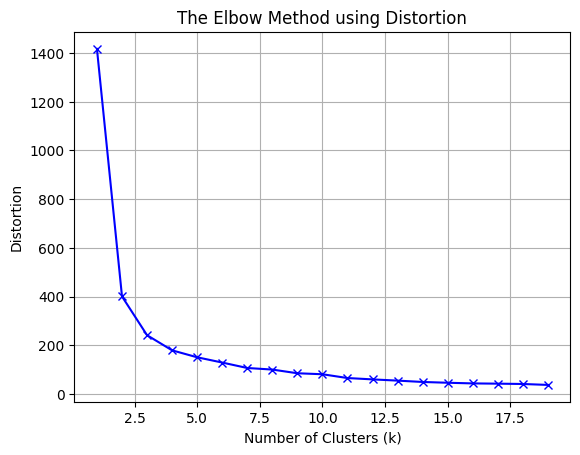

In [5]:
# Fit K-means for different values of k
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 20)
X = df_agg[[col for col in df_agg.columns if col not in excep_columns]].values
X = X.astype(float)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42).fit(X)
    
    # Calculate distortion as the average squared distance from points to their cluster centers
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)**2) / X.shape[0])
    
    # Inertia is calculated directly by KMeans
    inertias.append(kmeanModel.inertia_)
    
    # Store the mappings for easy access
    mapping1[k] = distortions[-1]
    mapping2[k] = inertias[-1]

print("Distortion values:")
for key, val in mapping1.items():
    print(f'{key} : {val}')
# Plotting the graph of k versus Distortion
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.grid()
plt.show()

In [6]:
# clusterer = HDBSCAN()
clusterer = KMeans(n_clusters=7, random_state=2747364364)
clusterer.fit(X=df_agg[[col for col in df_agg.columns if col not in excep_columns]])

KMeans(n_clusters=7, random_state=2747364364)

In [7]:
df_agg["cluster"] = clusterer.labels_.astype(str)
df_agg["day_name"] = df_agg["Fecha"].dt.day_name()

In [8]:
df_agg.cluster.nunique()

7

In [9]:
# with open("")

df_agg.groupby("cluster").agg({"Fecha": lambda x : list(x)}).to_dict()

{'Fecha': {'0': [Timestamp('2024-05-01 00:00:00'),
   Timestamp('2024-05-02 00:00:00'),
   Timestamp('2024-05-03 00:00:00'),
   Timestamp('2024-05-04 00:00:00'),
   Timestamp('2024-05-06 00:00:00'),
   Timestamp('2024-05-07 00:00:00'),
   Timestamp('2024-05-08 00:00:00'),
   Timestamp('2024-05-09 00:00:00'),
   Timestamp('2024-05-10 00:00:00'),
   Timestamp('2024-05-11 00:00:00'),
   Timestamp('2024-05-14 00:00:00'),
   Timestamp('2024-05-15 00:00:00'),
   Timestamp('2024-05-16 00:00:00'),
   Timestamp('2024-05-17 00:00:00'),
   Timestamp('2024-05-18 00:00:00'),
   Timestamp('2024-05-20 00:00:00'),
   Timestamp('2024-05-28 00:00:00'),
   Timestamp('2024-05-29 00:00:00'),
   Timestamp('2024-05-30 00:00:00'),
   Timestamp('2024-05-31 00:00:00'),
   Timestamp('2024-06-01 00:00:00'),
   Timestamp('2024-06-04 00:00:00'),
   Timestamp('2024-06-05 00:00:00'),
   Timestamp('2024-06-06 00:00:00'),
   Timestamp('2024-06-07 00:00:00'),
   Timestamp('2024-06-18 00:00:00'),
   Timestamp('2024-06-19

In [10]:
df_agg.groupby("cluster").agg({"Fecha": "count"}).to_dict()

{'Fecha': {'0': 61, '1': 41, '2': 46, '3': 41, '4': 28, '5': 54, '6': 56}}

In [11]:
import plotly.express as px
import plotly.graph_objects as go

In [12]:
fig = px.bar(
    data_frame=df_agg,
    x="Fecha",
    y="TOTAL_GEN",
    color="cluster",
    color_discrete_sequence=px.colors.qualitative.Set1,
    # hover_data=["week_of_year", "day_of_week", "is_holiday", "day_name"],
)
fig.add_traces(
    [
        go.Scatter(
            x=df_agg["Fecha"],
            y=df_agg["TERMICA"],
            mode='lines',
            line=dict(color='black', width=1),
            name="Termica",
        ),
        go.Scatter(
            x=df_agg["Fecha"],
            y=df_agg["HIDRAULICA"],
            mode='lines',
            line=dict(color='#ed6f1c', width=1),
            name="hidro",
        ),
    ]
)


fig.show()

In [13]:
centers = pd.DataFrame(
    data=clusterer.cluster_centers_,
    columns=[col for col in df_agg.columns if col not in excep_columns + ["cluster", "day_name"]],
    index=range(clusterer.n_clusters)
)
centers
df_agg["HIDRO_ERROR"] = df_agg.apply(
    lambda x: (x["HIDRAULICA"] - centers.loc[int(x["cluster"]), "HIDRAULICA"])**2, axis=1
)
df_agg["TERMICA_ERROR"] = df_agg.apply(
    lambda x: (x["TERMICA"] - centers.loc[int(x["cluster"]), "TERMICA"])**2, axis=1
)
df_agg["TOTAL_ERROR"] = df_agg["HIDRO_ERROR"] + df_agg["TERMICA_ERROR"]
min_error_dates = df_agg.loc[df_agg.groupby("cluster")["TOTAL_ERROR"].idxmin(), ["cluster", "Fecha", "TOTAL_ERROR"]]
min_error_dates

,cluster,Fecha,TOTAL_ERROR
138,0,2024-05-18,5.150181
54,1,2024-02-24,19.199196
86,2,2024-03-27,0.479999
35,3,2024-02-05,1.592008
223,4,2024-08-11,0.986452
239,5,2024-08-27,1.975254
60,6,2024-03-01,1.795734
